<a href="https://colab.research.google.com/github/ManishaArugula/Netflix_Customer_Churn/blob/main/Feature_Engineering%26Prediction_Netflix_Cutomer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook contains machine learning models that can predict whether a Netflix user churns.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [2]:
## because the dependent is categorical variable with binary values 0 and 1 , we can use the logistic regression
df = pd.read_csv('netflix_customer_churn.csv')
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [3]:
##take a copy of the dataset
data = df.copy()
data.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [4]:
### as observed in the EDA, we had outliers in the dataset, which will be capped
lower_bound, upper_bound = data['avg_watch_time_per_day'].quantile([0.01, 0.99])
print(lower_bound,upper_bound)

0.0 10.921600000000035


In [5]:
data[(data['avg_watch_time_per_day']>= lower_bound) & (data['avg_watch_time_per_day'] <= upper_bound)]

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,44f3ba44-b95d-4e50-a786-bac4d06f4a43,19,Female,Basic,49.17,11,Europe,Desktop,8.99,0,Credit Card,4,4.10,Drama
4996,18779bcb-ba2b-41da-b751-e70b812061ec,67,Female,Basic,9.24,2,North America,Desktop,8.99,0,PayPal,3,3.08,Documentary
4997,3f32e8c5-615b-4a3b-a864-db2688f7834f,66,Male,Standard,16.55,49,South America,Desktop,13.99,1,Debit Card,2,0.33,Action
4998,7b0ad82d-6571-430e-90f4-906259e0e89c,59,Female,Basic,9.12,3,Europe,Laptop,8.99,0,Credit Card,4,2.28,Sci-Fi


In [6]:
clean_df = data[(data['avg_watch_time_per_day']>= lower_bound) & (data['avg_watch_time_per_day'] <= upper_bound)]
clean_df.shape

(4950, 14)

In [7]:
##drop the customer id
clean_df = clean_df.drop(columns=['customer_id'])
clean_df

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,19,Female,Basic,49.17,11,Europe,Desktop,8.99,0,Credit Card,4,4.10,Drama
4996,67,Female,Basic,9.24,2,North America,Desktop,8.99,0,PayPal,3,3.08,Documentary
4997,66,Male,Standard,16.55,49,South America,Desktop,13.99,1,Debit Card,2,0.33,Action
4998,59,Female,Basic,9.12,3,Europe,Laptop,8.99,0,Credit Card,4,2.28,Sci-Fi


In [8]:
##split the dependent and independent variable
x= clean_df.drop(columns=['churned'])
y= clean_df['churned']


In [9]:
##split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y , test_size= 0.2, random_state= 42)


In [10]:
x_train_encoded = pd.get_dummies(x_train, drop_first=True)
x_test_encoded = pd.get_dummies(x_test, drop_first=True)

In [11]:
## try to fit the regression model on the x train and y train
lr = LogisticRegression()
lr.fit(x_train_encoded, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
y_pred = lr.predict(x_test_encoded)
accuracy_score(y_test,y_pred)

0.8848484848484849

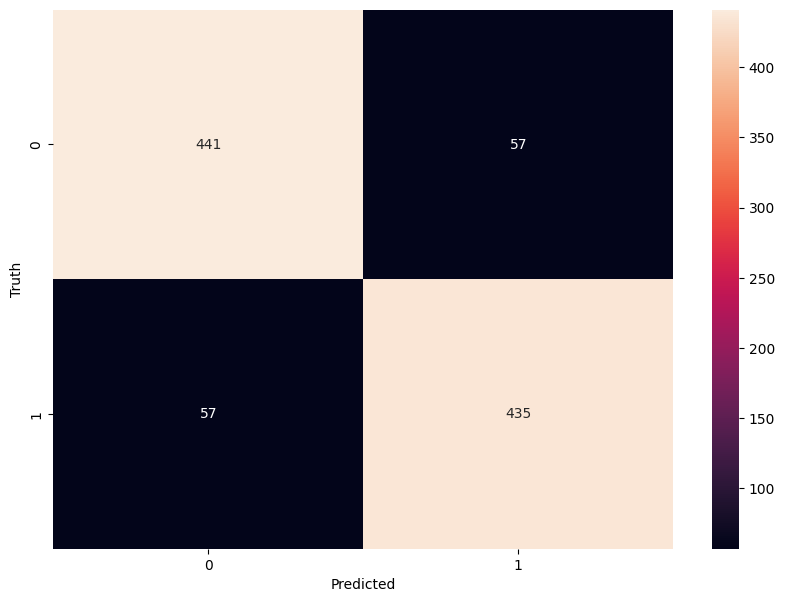

In [13]:
## print the confusion matrix in heatmap form
cm =confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [14]:
print(classification_report(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, lr.predict_proba(x_test_encoded)[:,1]))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       498
           1       0.88      0.88      0.88       492

    accuracy                           0.88       990
   macro avg       0.88      0.88      0.88       990
weighted avg       0.88      0.88      0.88       990

ROC-AUC 0.9637737943644497


In [15]:
### check if one hot encoding will improve the accuracy of the model?
## get all the categorical columns from the x table
cat_features = x.select_dtypes(include='object').columns.tolist()
cat_features
num_features = x.select_dtypes(exclude='object').columns.tolist()
num_features

['age',
 'watch_hours',
 'last_login_days',
 'monthly_fee',
 'number_of_profiles',
 'avg_watch_time_per_day']

In [16]:
##use onehot encoding on cat features which are used in the x dataframe
from sklearn.pipeline import Pipeline
preprocess = ColumnTransformer(transformers=[
    ('cat',OneHotEncoder(drop='first'), cat_features),
    ('num', 'passthrough', num_features)
    ])


xgb_model = Pipeline(steps=[
    ('preprocess',preprocess),
    ('model',LogisticRegression())
])

xgb_model.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender',
                                                   'subscription_type',
                                                   'region', 'device',
                                                   'payment_method',
                                                   'favorite_genre']),
                                                 ('num', 'passthrough',
                                                  ['age', 'watch_hours',
                                                   'last_login_days',
                                                   'monthly_fee',
                                                   'number_of_profiles',
                                                   'avg_watch_time_per_day'])])),
                ('model', LogisticRegression())])

In [17]:
y_pred = xgb_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.8848484848484849

### Feature Engineering

In [18]:
df_eng = clean_df.copy()
df_eng

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,19,Female,Basic,49.17,11,Europe,Desktop,8.99,0,Credit Card,4,4.10,Drama
4996,67,Female,Basic,9.24,2,North America,Desktop,8.99,0,PayPal,3,3.08,Documentary
4997,66,Male,Standard,16.55,49,South America,Desktop,13.99,1,Debit Card,2,0.33,Action
4998,59,Female,Basic,9.12,3,Europe,Laptop,8.99,0,Credit Card,4,2.28,Sci-Fi


In [19]:
## from the previous insights we know that profiles equal to or less than 3 churn and more do not
## Age can be categorised to age groups
bins = [17,31,45,59,73]
df_eng['age_group'] = pd.cut(df_eng['age'], bins =bins, labels=['Young Adults(17-30)','Mid-Age Adults(31-44)','Older Adults(45-58)','Senior Adults(59-70)'])
df_eng.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre,age_group
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action,Older Adults(45-58)
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi,Older Adults(45-58)
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama,Young Adults(17-30)
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror,Older Adults(45-58)
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action,Older Adults(45-58)


In [20]:
## From EDA : number of profiles > 3  churn less and subscription type as premium and standrad churn less
df_eng['many_profiles']= np.where(df_eng['number_of_profiles']> 3, 1,0)

In [21]:
def sub(x):
  if x=='Premium' or x=='Standard':
    return 1
  else:
    return 0


In [22]:
df_eng['higher_plan'] = df_eng['subscription_type'].apply(sub)

In [23]:
df_eng['loyal_cus'] = ((df_eng['many_profiles']==1) & (df_eng['higher_plan']==1)).astype(int)

In [24]:
df_eng.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre,age_group,many_profiles,higher_plan,loyal_cus
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action,Older Adults(45-58),0,0,0
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi,Older Adults(45-58),1,1,1
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama,Young Adults(17-30),0,1,0
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror,Older Adults(45-58),0,1,0
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action,Older Adults(45-58),0,1,0


In [25]:
##drop the unnecassary columns
df_eng = df_eng.drop(columns =['age','subscription_type','number_of_profiles'])
df_eng.head()

,gender,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,avg_watch_time_per_day,favorite_genre,age_group,many_profiles,higher_plan,loyal_cus
0,Other,14.73,29,Africa,TV,8.99,1,Gift Card,0.49,Action,Older Adults(45-58),0,0,0
1,Other,0.70,19,Europe,Mobile,13.99,1,Gift Card,0.03,Sci-Fi,Older Adults(45-58),1,1,1
2,Female,16.32,10,Asia,TV,13.99,0,Crypto,1.48,Drama,Young Adults(17-30),0,1,0
3,Other,4.51,12,Oceania,TV,17.99,1,Crypto,0.35,Horror,Older Adults(45-58),0,1,0
4,Other,1.89,13,Africa,Mobile,13.99,1,Crypto,0.13,Action,Older Adults(45-58),0,1,0


In [26]:
##split the dependent and independent variable
x= df_eng.drop(columns=['churned'])
y= df_eng['churned']

x_train, x_test, y_train, y_test = train_test_split(x,y , test_size= 0.2, random_state= 42)
x_train_encoded = pd.get_dummies(x_train, drop_first=True)
x_test_encoded = pd.get_dummies(x_test, drop_first=True)

In [27]:
lr2 = LogisticRegression()
lr2.fit(x_train_encoded, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
y_pred = lr2.predict(x_test_encoded)
accuracy_score(y_test,y_pred)

0.9101010101010101

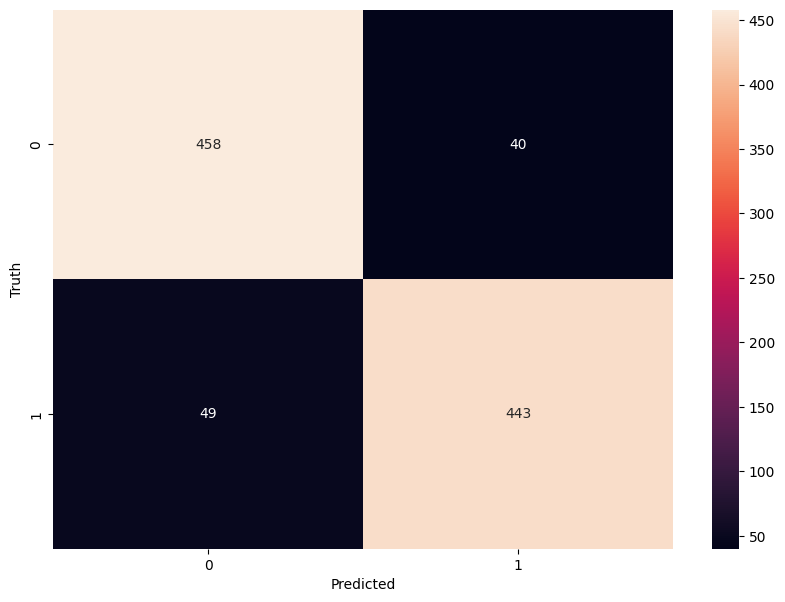

In [29]:
## print the confusion matrix in heatmap form
cm =confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       498
           1       0.92      0.90      0.91       492

    accuracy                           0.91       990
   macro avg       0.91      0.91      0.91       990
weighted avg       0.91      0.91      0.91       990



In [31]:
print("ROC AUC:", roc_auc_score(y_test, lr2.predict_proba(x_test_encoded)[:, 1]))

ROC AUC: 0.9684469585659711


In [32]:
param_grid = {
    'C': [0.001, 0.1, 1, 10],     ## lasso and ridge  regularisation values
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train_encoded, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated accuracy: 0.9070707070707071


In [33]:
## model with xgboost

xgb = XGBClassifier()
xgb.fit(x_train_encoded, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
y_pred = xgb.predict(x_test_encoded)
accuracy_score(y_test,y_pred)

0.9868686868686869

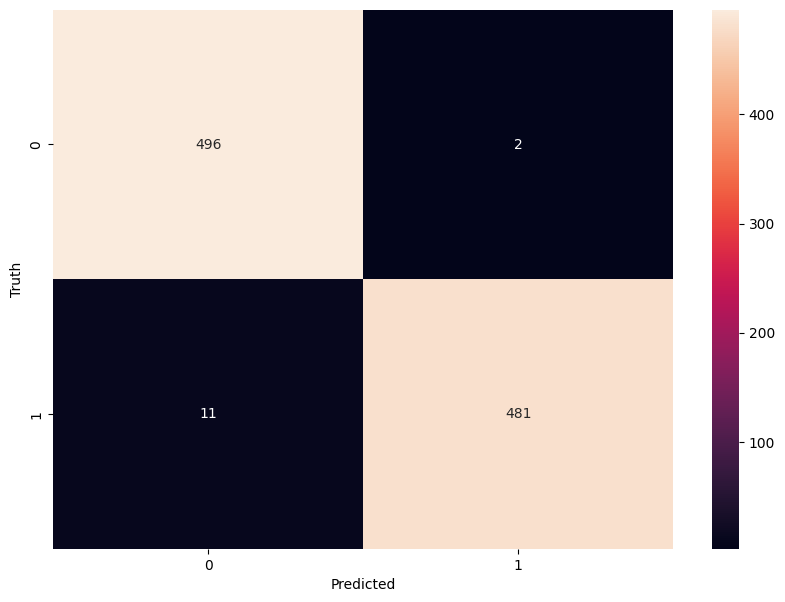

In [35]:
## print the confusion matrix in heatmap form
cm =confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [36]:
##AUC-roc and performance metrics
print(classification_report(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, xgb.predict_proba(x_test_encoded)[:,1]))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       498
           1       1.00      0.98      0.99       492

    accuracy                           0.99       990
   macro avg       0.99      0.99      0.99       990
weighted avg       0.99      0.99      0.99       990

ROC-AUC 0.9992122963398309


## The accuracy improved to 91% in logistic regression with some amount of feature engineering, where as the XGBoost was able to outperform with 98% accuracy with just raw data.